In [1]:
import numpy as np
from scipy.stats import norm

#finds the respective standard deviation for the position and frequency
def sigma_matrix(pos_sigma, freq_sigma):
    pos_sigma = np.asarray(pos_sigma)
    freq_sigma = np.asarray(freq_sigma)
    
    # Broadcast: (4,1) + (1,7) → (4,7)
    mat = np.exp(freq_sigma[:, None] + pos_sigma[None, :])
    return mat

#noise = P(O_t+1 | true k_t, freq_t)
#prior = P(O_t+1 | O_1:t)
#P(O_t+1 | O_1:t, true k_t, freq_t)
def gaussian_overlap_weights(prior, means, sigma_matrix_, f_idx, true_k):
    mean_q = means[true_k]
    sigma_q = sigma_matrix_[f_idx][true_k]
    means = np.asarray(means, float)
    sigmas = np.asarray(sigma_matrix_[f_idx], float)

    var_sum = sigma_q**2 + sigmas**2
    noise = -0.5*np.log(2*np.pi*var_sum) - 0.5*((means - mean_q)**2)/var_sum

    #have to deal with zeros in log
    prior = np.asarray(prior, float)
    logprior = np.log(prior)

    decision_prior = noise + logprior

    # softmax to get a length-7 vector summing to 1, lose information if value is more than 10^14 apart
    m = np.max(decision_prior)
    w = np.exp(decision_prior - m)
    return w / w.sum()


#Higher lamdha means more bias towards FAing at 1 - 3
def apply_lapse(lamdha, decision_prior):
    return (1.0 - lamdha)*decision_prior + lamdha * np.array([1/3, 1/3, 1/3, 0, 0, 0, 0])


In [3]:
import numpy as np
import matplotlib.pyplot as plt

observations = ['Dev at 1', 'Dev at 2','Dev at 3','Dev at 4','Dev at 5','Dev at 6', 'No deviant']
freqencies = [4, 8, 16, 32]



def change_point_model(trial_by_global_param = None, trial_by_logic_param = None, lamdha_param = None, pos_sigma_param = None, freq_sigma_param = None):
    

    ######## Initialize Global Variables ########
    
    def initialize_likelihoods(trial_by_global_ = None, trial_logic_ = None, lamdha_ = None, pos_sigma_ = None, freq_sigma_ = None):

        trial_by_global = trial_by_global_

        if(trial_logic_ is None):
            trial_logic = np.array([
                #HM
                [0, 0, 0, 0.33, 0.33, 0.33, 0],
                #FC
                [0, 0, 0, 0, 0, 0, 1]
            ]).T
        else:
            trial_logic = trial_logic_

        FUTURE_GIVEN_STATE = trial_logic @ trial_by_global

        means = np.array([1, 2, 3, 4, 5, 6, -2]) ### Farther Mu doesn't affect it for some reason?

        lamdha = lamdha_

        matrix = sigma_matrix(pos_sigma_, freq_sigma_)

        return trial_by_global, trial_logic, FUTURE_GIVEN_STATE, means, lamdha, matrix

    trial_by_global, trial_logic, FUTURE_GIVEN_STATE, means, lamdha, sigs = initialize_likelihoods(trial_by_global_param, 
                                                                                                                        trial_by_logic_param, 
                                                                                                                        lamdha_param, pos_sigma_param, 
                                                                                                                        freq_sigma_param)
    assert np.allclose(trial_logic.sum(axis=0), [1.0, 1.0], atol=1e-12)




    ######## HELPER FUNCTIONS FOR INTERNAL BELIEF UPDATING ########





    def initialize_priors_and_history(global_prior = None, belief_over_time = None, decision_over_time = None, decision_history = None):
        if (belief_over_time is None or decision_history is None or decision_over_time is None):          
            global_prior = np.array([1/3, 1/3, 1/3])
            belief_over_time = [] 
            decision_over_time = []
            decision_history = []

        else:
            global_prior = global_prior
            belief_over_time = belief_over_time  
            decision_over_time = decision_over_time
            decision_history = decision_history

        deviant_given_sequence = np.array([1/7, 1/7, 1/7, 1/7, 1/7, 1/7, 1/7])      

        return deviant_given_sequence, global_prior, belief_over_time, decision_over_time, decision_history

    def sequence_given_state(sequence, trial_by_global, trial_logic):
        deviant_given_state = np.ones(3)
        for i in range(len(sequence)):
            if (sequence[i] == 'FA/Miss'):
                continue
            deviant_given_trial = np.array([trial_logic[sequence[i]][0], trial_logic[sequence[i]][1]])
            deviant_given_state *= deviant_given_trial @ trial_by_global
            deviant_given_state = deviant_given_state / deviant_given_state.sum()

        return deviant_given_state

    #state_prob (just the global type probability) is 1/3 for all three, could change to free
    #doesn't really matter here since uniform for all three but if we want to change overall chance between global types do it here
    def state_given_sequence(sequence, state_prob, trial_by_global, trial_logic):
        SEQUENCE_GIVEN_STATE = sequence_given_state(sequence, trial_by_global, trial_logic)
        state_given_sequence = SEQUENCE_GIVEN_STATE * state_prob
        norm_state_given_sequence = state_given_sequence / state_given_sequence.sum()
        return norm_state_given_sequence

    def future_given_sequence(sequence, prior, trial_by_global, trial_logic):
        STATE_GIVEN_SEQUENCE = state_given_sequence(sequence, prior, trial_by_global, trial_logic)    
        
        return FUTURE_GIVEN_STATE @ STATE_GIVEN_SEQUENCE.T

    def update_priors_simplified(global_prior, trial_by_global, trial_logic, decision_history):    

        size = len(decision_history)

        if (size % 250 == 0 or size == 0):
            deviant_given_sequence = np.array([1/7, 1/7, 1/7, 1/7, 1/7, 1/7, 1/7])
            return deviant_given_sequence
        
        else:
            index = (size // 250) * 250 if ((size // 250) != 0) else 1
            clipped_decision_history = decision_history[index - 1: size].copy()
            deviant_given_sequence = future_given_sequence(clipped_decision_history, global_prior, trial_by_global, trial_logic)

            return deviant_given_sequence


    




    ######## FUNCTION FOR RUNNING TRIALS ########




    #decision_over_time is prior of possible choices the agent wants to make
    #decision_history is the single choice that was randomly sampled from each prior (decision_over_time) for each trial
    def run_trials(Global_type = None, global_prior_ = None, belief_over_time_ = None, decision_over_time_ = None, decision_history = None, n_trials = 1000):

        deviant_given_sequence, global_prior, belief_over_time, decision_over_time, decision_history = initialize_priors_and_history(global_prior_, 
                                                                                        belief_over_time_, decision_over_time_, decision_history)
        
        for trial in range(n_trials):        
            # Randomly choose where the deviant is located based on global_type
            deviant_position = 0
            if (Global_type == "Standard"):
                deviant_position = np.random.randint(3, 6)
            elif (Global_type == "Probe"):
                positions = [3, 4, 5, 6]
                probabilities = [0.95/3, 0.95/3, 0.95/3, 0.05]
                deviant_position = np.random.choice(positions, size=1, p=probabilities)[0]
            elif (Global_type == "Catch"):
                positions = [3, 4, 5, 6]
                probabilities = [0.6/3, 0.6/3, 0.6/3, 0.4]  # 60% for positions 3, 4, 5; 40% for position 7
                deviant_position = np.random.choice(positions, size=1, p=probabilities)[0]
            else:
                ValueError("Global type is not valid argument")

            #Randomly choose frequency (not accurate but good enough)
            f_index = np.random.randint(0, 4)

            noisey_observation = gaussian_overlap_weights(deviant_given_sequence, means, sigs, f_index, deviant_position)
            more_noisey_observation = apply_lapse(lamdha, noisey_observation)
            decision_over_time.append(more_noisey_observation)

            # Randomly choose a decision using this noisey observation
            choice_index = np.random.choice(len(more_noisey_observation), p=more_noisey_observation)
            decision_from_observation = choice_index
            
            #If FA early no meaningful update so just keep same belief. Also just only reinforce if hit/CR
            if (decision_from_observation < 3):
                if (len(belief_over_time) % 250 == 0):
                    deviant_given_sequence = np.array([1/7, 1/7, 1/7, 1/7, 1/7, 1/7, 1/7])
                    decision_history.append('FA/Miss')
                    belief_over_time.append(deviant_given_sequence)
                    continue
                deviant_given_sequence = belief_over_time[len(belief_over_time) - 1]
                decision_history.append('FA/Miss')
                belief_over_time.append(deviant_given_sequence)
                continue
            else:
                decision_history.append(decision_from_observation)

            # After each trial, update the predicted observation based on the new decision sequence
            deviant_given_sequence = update_priors_simplified(global_prior, trial_by_global, trial_logic, decision_history)
            belief_over_time.append(deviant_given_sequence.copy())

        
        return belief_over_time, decision_over_time, decision_history



    belief_over_time, decision_over_time, decision_history = run_trials("Standard", None, None, None, None, n_trials = 1500)

    global_prior = np.array([1/3, 1/3, 1/3])

    for trials in range(5):
        belief_over_time, decision_over_time, decision_history = run_trials("Standard", global_prior, belief_over_time, decision_over_time, decision_history, n_trials = 250)
        belief_over_time, decision_over_time, decision_history = run_trials("Probe", global_prior, belief_over_time, decision_over_time, decision_history, n_trials = 250)
        belief_over_time, decision_over_time, decision_history = run_trials("Standard", global_prior, belief_over_time, decision_over_time, decision_history, n_trials = 500)
        belief_over_time, decision_over_time, decision_history = run_trials("Probe", global_prior, belief_over_time, decision_over_time, decision_history, n_trials = 250)
        belief_over_time, decision_over_time, decision_history = run_trials("Standard", global_prior, belief_over_time, decision_over_time, decision_history, n_trials = 250)

    belief_over_time, decision_over_time, decision_history = run_trials("Catch", global_prior, belief_over_time, decision_over_time, decision_history, n_trials = 1500)



    def _add_demarcations(ax, trials_to_demarcate, labels):
        trials_to_demarcate = np.asarray(trials_to_demarcate, int)
        assert len(labels) == len(trials_to_demarcate), \
            "labels and trials_to_demarcate must have the same length."

        # Vertical lines + top labels centered in each segment (except the last marker)
        for i, t in enumerate(trials_to_demarcate):
            ax.axvline(t, linestyle="--", linewidth=1, alpha=0.6)
            if i < len(trials_to_demarcate) - 1:
                mid = (trials_to_demarcate[i] + trials_to_demarcate[i+1]) / 2
                ax.text(mid, 1.02, labels[i], ha="center", va="bottom", fontsize=9, rotation=0,
                        transform=ax.get_xaxis_transform())
        # Put last label at far right
        ax.text(trials_to_demarcate[-1], 1.02, labels[-1], ha="left", va="bottom", fontsize=9,
                transform=ax.get_xaxis_transform())

    # ---------- Belief plot ----------
    def plot_belief_evolution(belief_over_time, trials_to_demarcate, labels, title="Belief over time"):
        """
        belief_over_time: list/array of shape (T, 7)
                        order assumed: Dev@1..Dev@6, No deviant (per your code)
        """
        B = np.asarray(belief_over_time, float)  # (T, 7)
        T = B.shape[0]

        fig, ax = plt.subplots(figsize=(10, 4))
        xs = np.arange(T)

        names = [f"Dev at {k}" for k in range(1, 7)] + ["No deviant"]
        for j in range(7):
            ax.plot(xs, B[:, j], label=names[j], linewidth=1.5)

        ax.set_xlim(0, T)
        ax.set_ylim(0.0, 1.0)
        ax.set_xlabel("Trial")
        ax.set_ylabel("Probability")
        ax.set_title(title)
        ax.legend(ncol=4, fontsize=8, frameon=False, loc="upper center", bbox_to_anchor=(0.5, -0.15))

        _add_demarcations(ax, trials_to_demarcate, labels)
        plt.tight_layout()
        plt.show()
    
    def plot_decision_evolution(decision_over_time, trials_to_demarcate, labels, title="Decision prior over time"):
        D = np.asarray(decision_over_time, float)  # (T, 7)
        T = D.shape[0]

        fig, ax = plt.subplots(figsize=(10, 4))
        xs = np.arange(T)

        names = [f"Dev at {k}" for k in range(1, 7)] + ["No deviant"]
        for j in range(7):
            ax.plot(xs, D[:, j], label=names[j], linewidth=1.2)

        ax.set_xlim(0, T)
        ax.set_ylim(0.0, 1.0)
        ax.set_xlabel("Trial")
        ax.set_ylabel("Probability")
        ax.set_title(title)
        ax.legend(ncol=4, fontsize=8, frameon=False, loc="upper center", bbox_to_anchor=(0.5, -0.15))

        _add_demarcations(ax, trials_to_demarcate, labels)
        plt.tight_layout()
        plt.show()
    
    
    trials_to_demarcate = [0, 1500, 2000, 2500, 3000, 3250, 3500, 5000]  # example—adjust to your phases
    labels = ["Training", "Std", "Probe", "Std", "Probe", "Std", "Catch-start", "Catch"]

    plot_belief_evolution(belief_over_time, trials_to_demarcate, labels, title="Belief: P(deviant@k | history)")
    plot_decision_evolution(decision_over_time, trials_to_demarcate, labels, title="Decision distribution used each trial")


    return decision_over_time




[3. 5. 5. ... 6. 6. 3.]
|   iter    |  target   | hm_sta... | hm_probe  | hm_catch  |   dev4    |  lamdha_  |    a1     |    a2     |    a3     |    a4     |    a5     |    a6     |    a7     |    f1     |    f2     |    f3     |    f4     |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


C:\Users\Fatbu\AppData\Local\Temp\ipykernel_16148\1259146926.py:27: RuntimeWarning: divide by zero encountered in log
  logprior = np.log(prior)


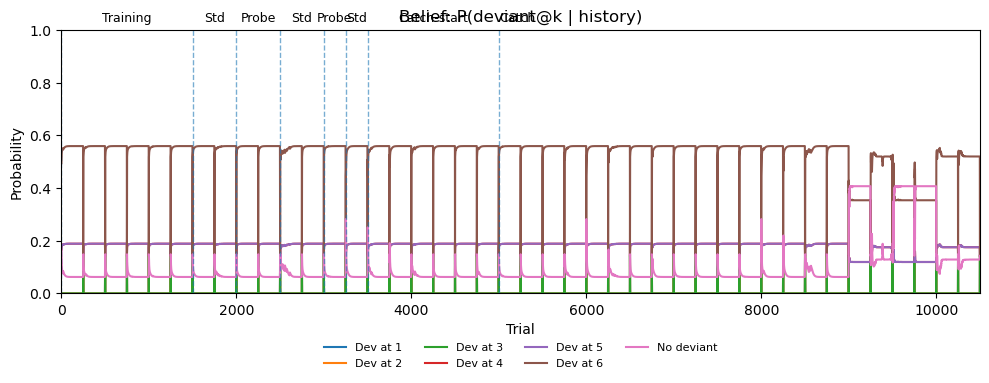

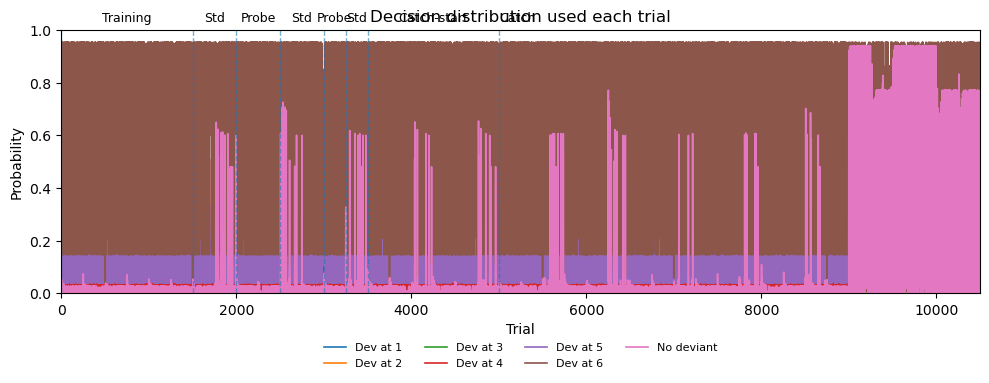

| 1         | -19375.74 | 0.8711626 | 0.9373285 | 0.5927975 | 0.2015707 | 0.0003120 | -1.032016 | -1.325749 | 1.0985284 | 0.3033450 | 0.6242177 | -1.438246 | 1.4097295 | 0.9973279 | -0.862982 | -0.954525 | -0.949786 |


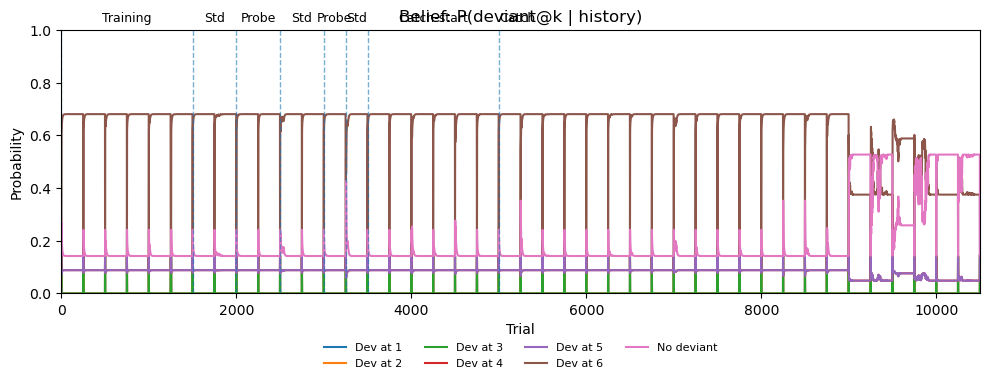

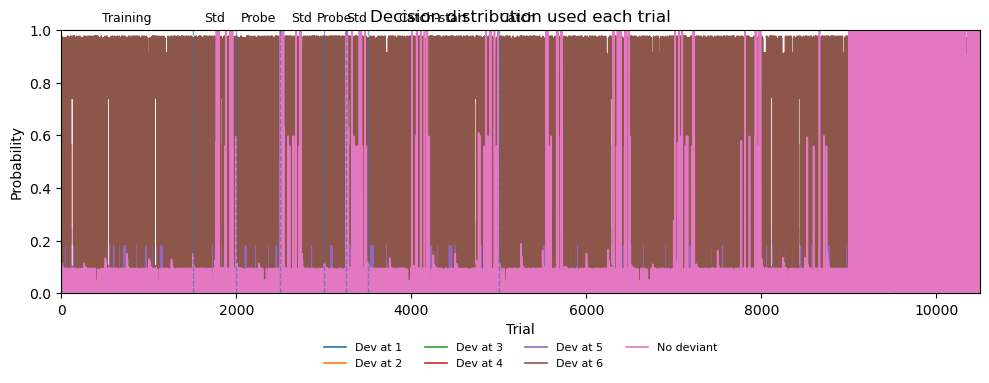

| 2         | -30427.00 | 0.8578060 | 0.7413879 | 0.4727780 | 0.1031933 | 0.0012237 | -1.081518 | -0.623566 | -0.400914 | -0.131790 | 0.8555278 | -0.900978 | 0.0427033 | 0.2772437 | -1.360648 | 0.3226345 | -0.988427 |


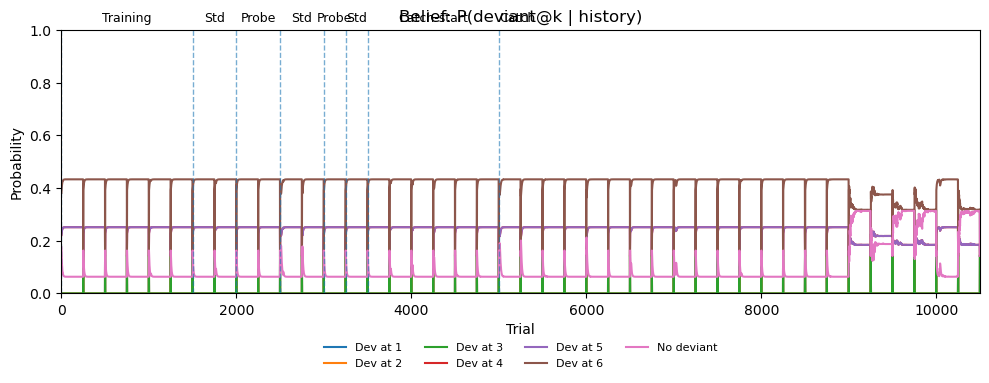

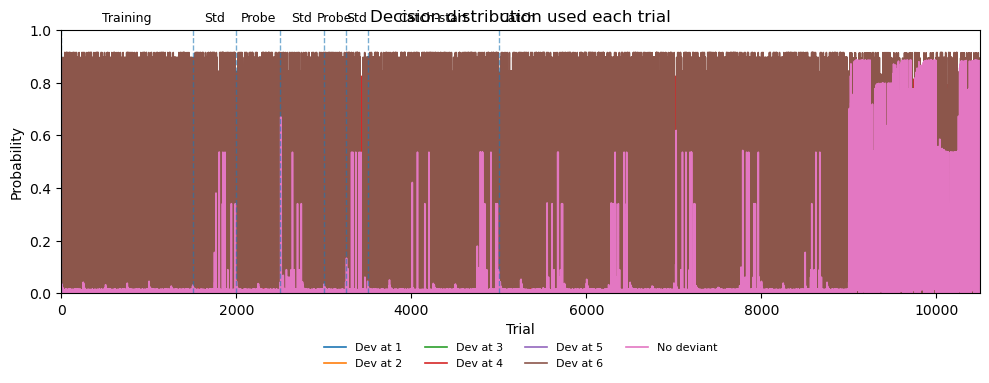

| 3         | -32232.82 | 0.8123598 | 0.9364873 | 0.6862528 | 0.2686871 | 0.0006092 | -1.206983 | 0.5526990 | -0.179542 | -1.133885 | -0.014469 | -1.396834 | 1.2279612 | -0.723660 | 0.4875668 | -0.564866 | 0.0602040 |


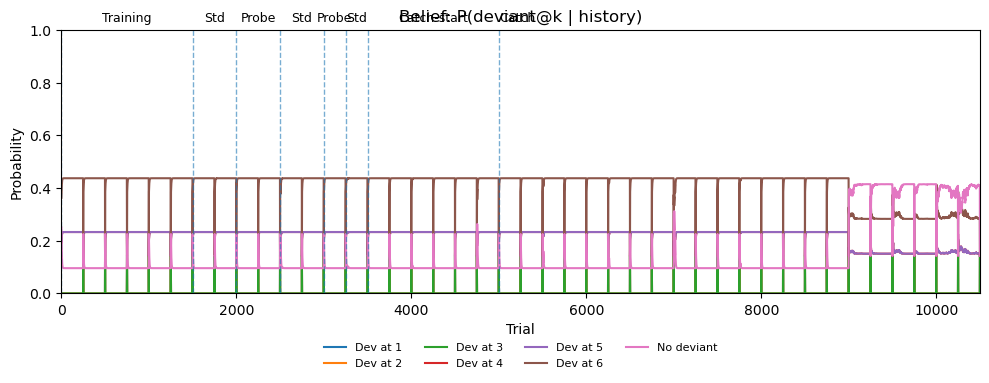

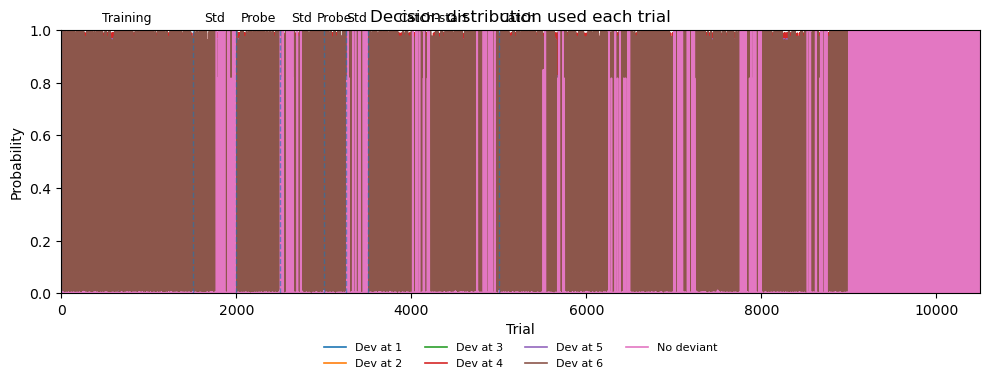

| 4         | -64678.82 | 0.9038749 | 0.5850330 | 0.6878338 | 0.2580425 | 0.0018789 | 1.1844820 | 0.2936999 | 1.2656227 | -1.234522 | -0.912051 | -1.364318 | -0.524009 | -0.333968 | -0.685952 | 0.9862125 | -0.429740 |


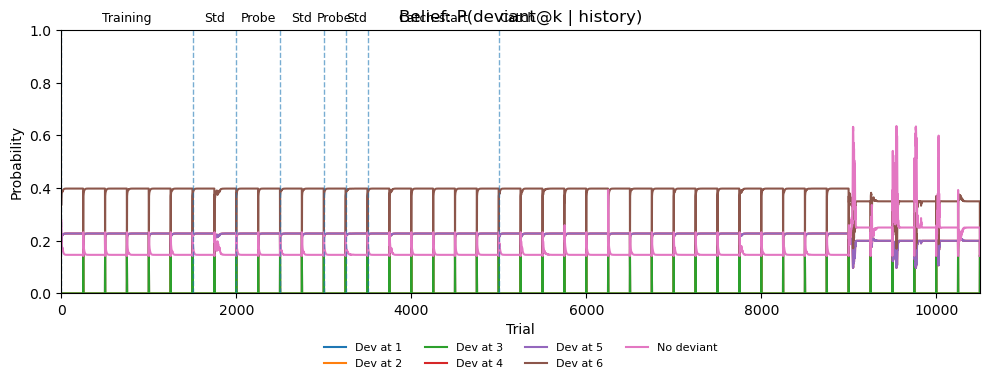

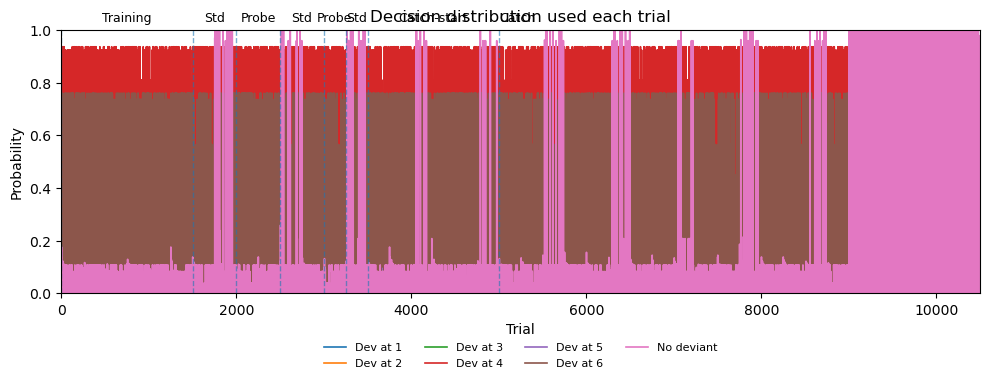

| 5         | -29026.31 | 0.8533775 | 0.7496401 | 0.3563696 | 0.2667030 | 0.0001491 | 1.4606608 | 0.8167343 | -0.903852 | -1.483433 | 0.9463842 | 0.6205720 | 0.6870215 | 0.8138110 | -1.277866 | -0.424602 | -1.152392 |


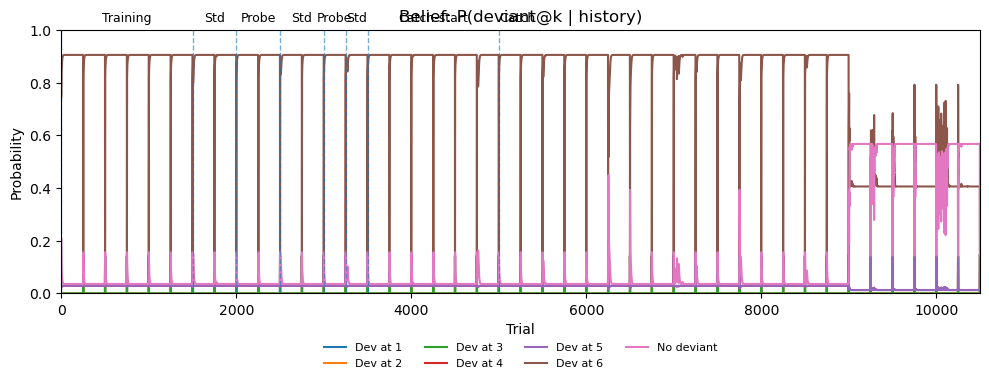

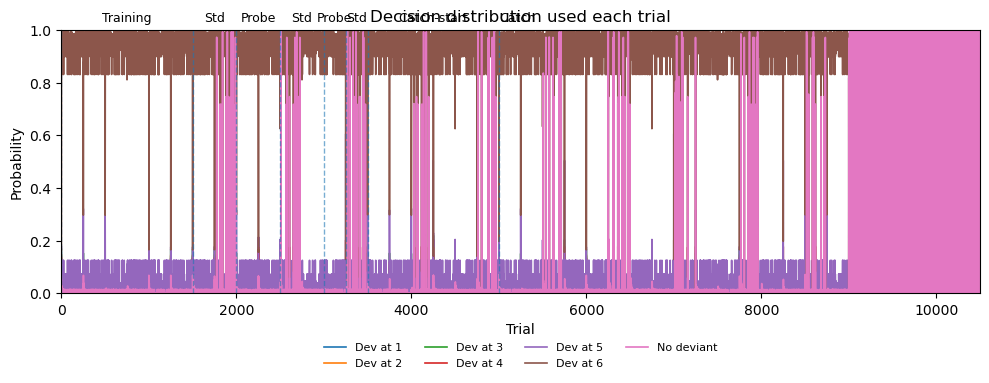

| 6         | -35131.21 | 0.9639896 | 0.7867171 | 0.4323592 | 0.0303386 | 0.0006219 | -0.524450 | 0.6888185 | 0.4126724 | 1.1616382 | -0.083355 | -1.141217 | 0.6397343 | 0.7823551 | 0.1838315 | 0.8129015 | -0.018613 |


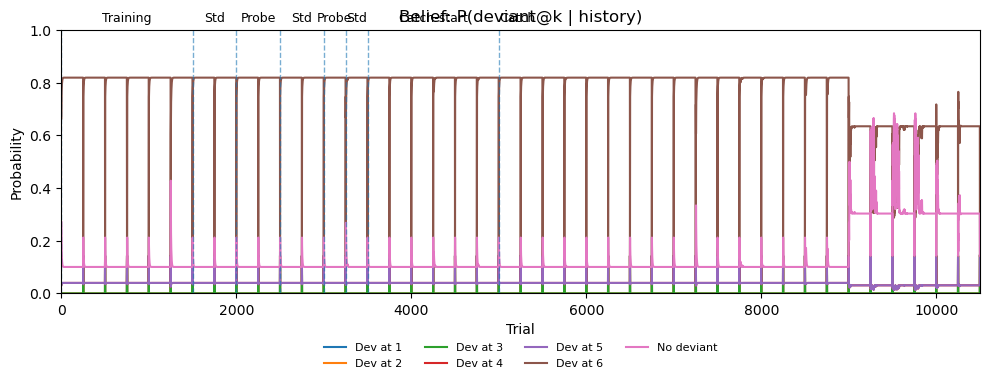

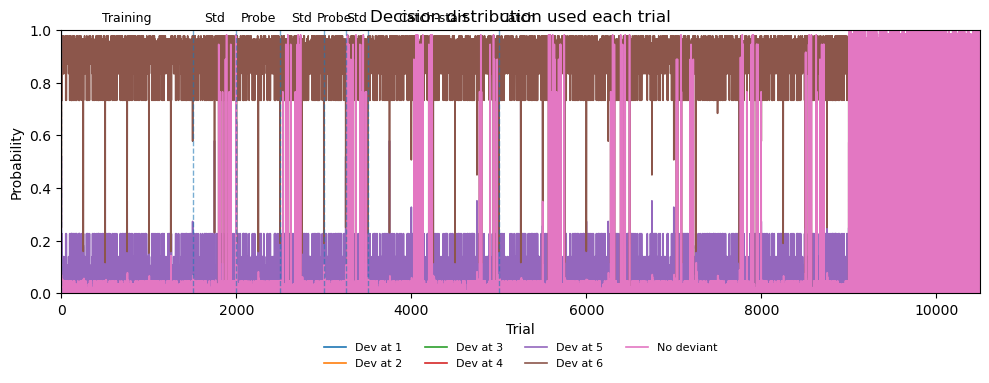

| 7         | -27527.40 | 0.8993192 | 0.6966688 | 0.3101676 | 0.0445252 | -.285e-05 | 0.4092312 | -0.556932 | 0.0257120 | 1.2226994 | -0.752123 | -0.268851 | 0.7666534 | -0.813605 | -1.269060 | -0.630745 | -1.016336 |


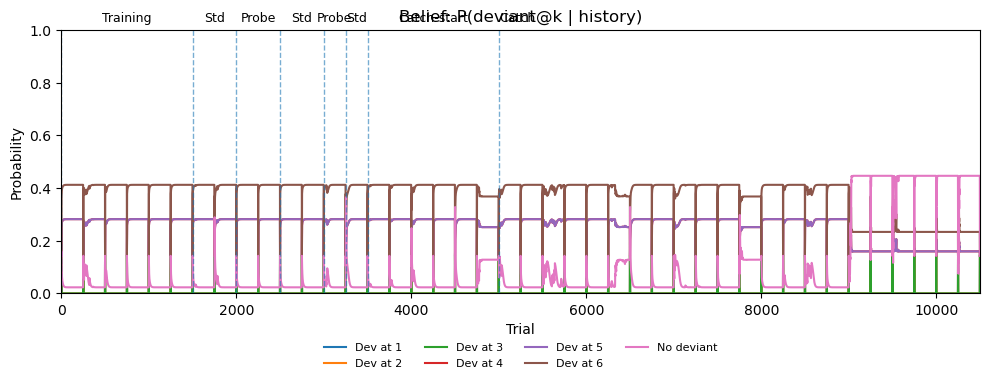

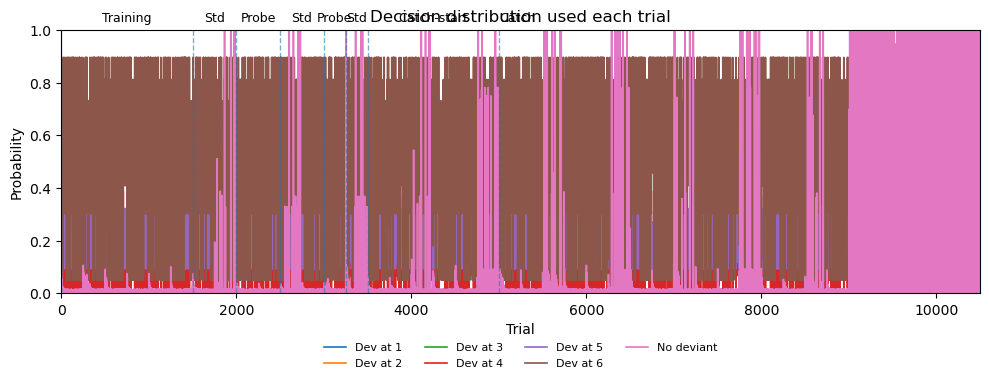

| 8         | -27510.33 | 0.9766425 | 0.8717353 | 0.5533615 | 0.2888673 | 0.0016073 | -0.940289 | 1.1776769 | 0.1180267 | 0.9223204 | 1.1882738 | -0.545989 | -1.169844 | -0.816194 | -0.218676 | 0.9540442 | 1.0821917 |


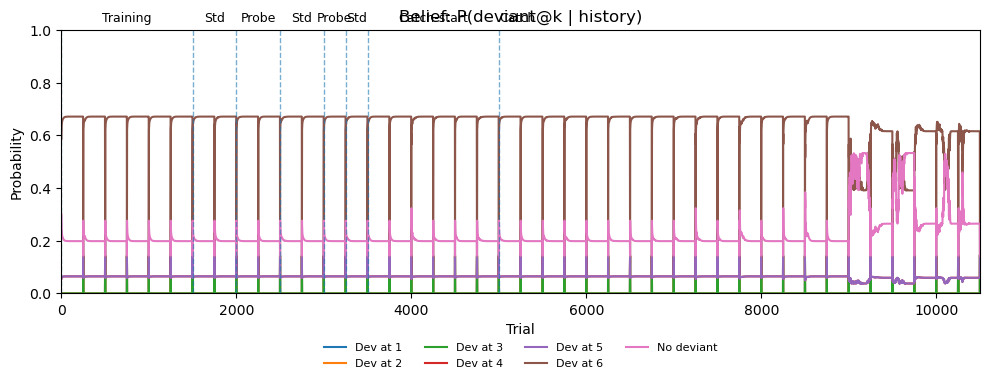

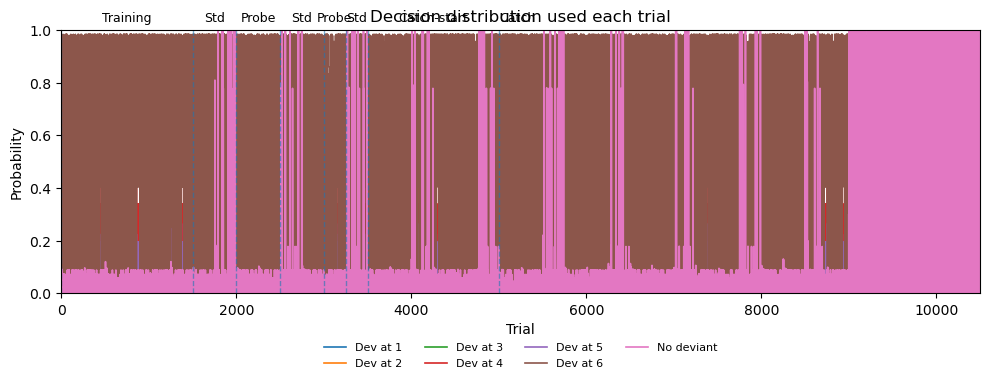

| 9         | -29620.97 | 0.8013209 | 0.7349437 | 0.4669644 | 0.0810744 | 0.0002397 | -0.487154 | 1.3287291 | -0.530391 | 0.0563718 | 0.6090568 | -0.409111 | 1.4153462 | 1.3873418 | -0.744653 | -0.008254 | -0.597365 |


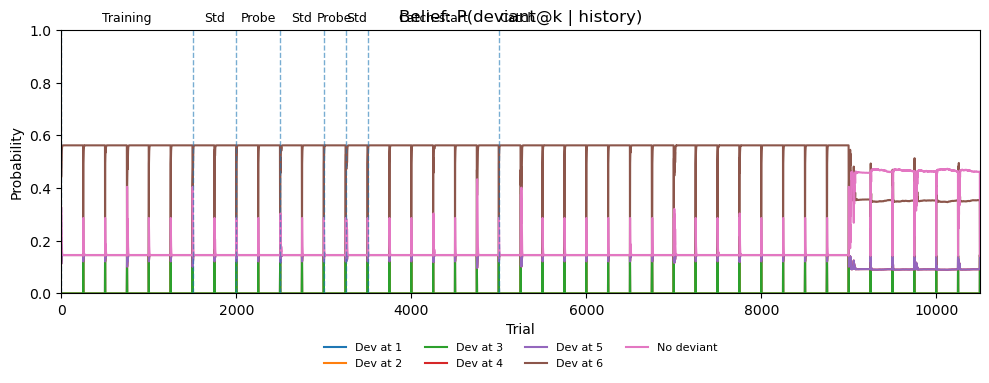

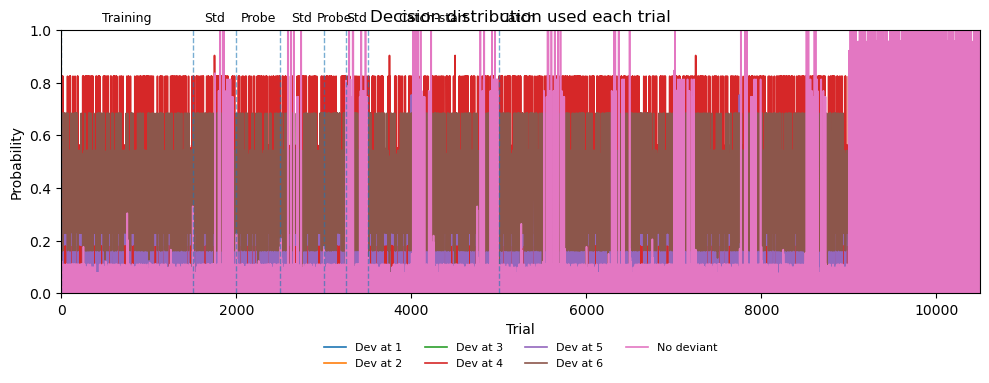

| 10        | -27032.47 | 0.8541196 | 0.5169679 | 0.5438257 | 0.1708572 | 0.0001029 | -0.664060 | 1.2247976 | -0.781314 | -1.065315 | -0.031641 | 1.4569513 | -0.773834 | 0.5164066 | 0.7848588 | -0.787087 | 0.6846490 |


C:\Users\Fatbu\AppData\Local\Temp\ipykernel_16148\1259146926.py:27: RuntimeWarning: divide by zero encountered in log
  logprior = np.log(prior)


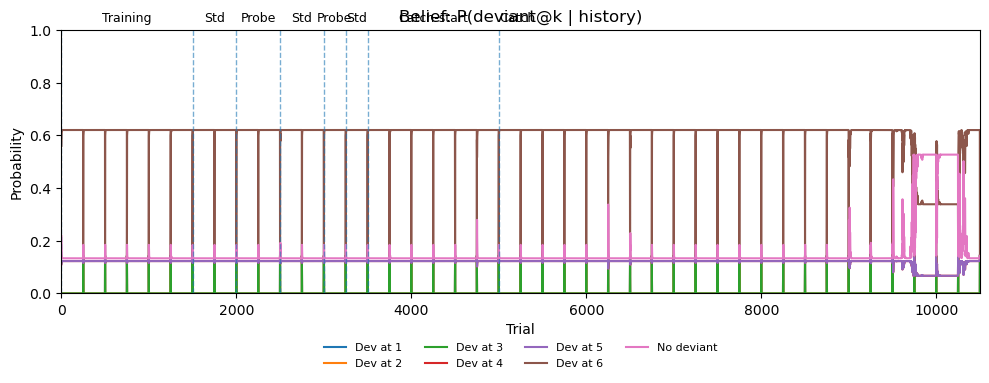

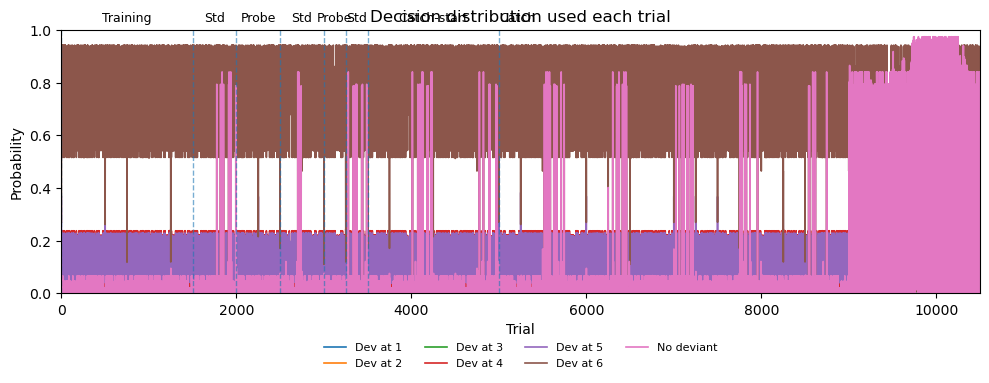

| 11        | -19075.85 | 0.8671977 | 0.8656070 | 0.4729558 | 0.1419782 | -.216e-05 | -0.599421 | -1.124419 | 0.5834228 | 0.6992312 | 0.2500394 | -0.891049 | 1.3615233 | 0.4012657 | -1.133612 | -1.081224 | -1.075328 |


C:\Users\Fatbu\AppData\Local\Temp\ipykernel_16148\1259146926.py:27: RuntimeWarning: divide by zero encountered in log
  logprior = np.log(prior)


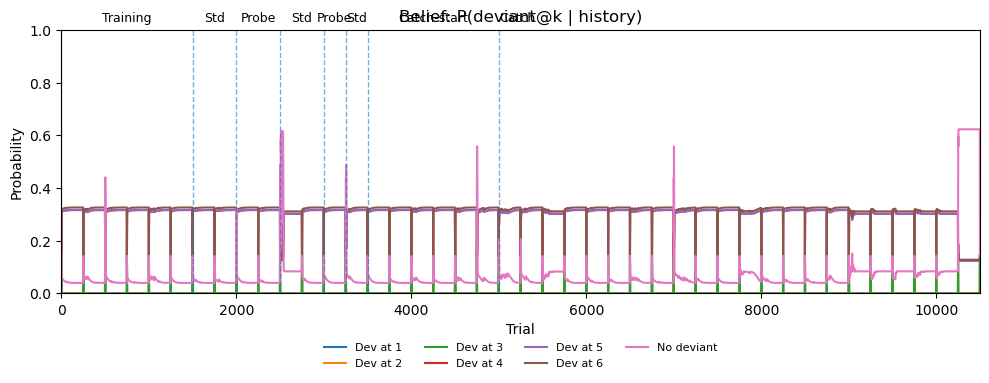

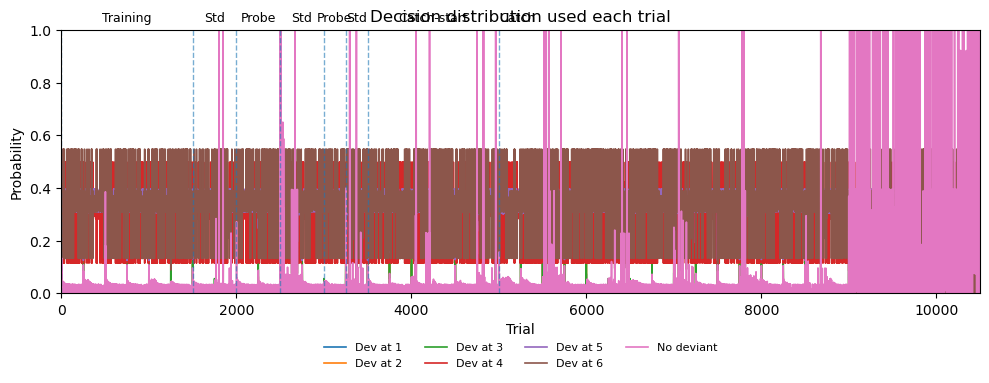

| 12        | -16940.71 | 0.9159845 | 0.96      | 0.3768377 | 0.33      | 0.0       | -1.5      | -1.5      | 0.3809277 | 1.5       | 1.5       | 1.3199831 | 1.5       | 0.6535065 | -0.490930 | -1.5      | -0.102133 |


C:\Users\Fatbu\AppData\Local\Temp\ipykernel_16148\1259146926.py:27: RuntimeWarning: divide by zero encountered in log
  logprior = np.log(prior)


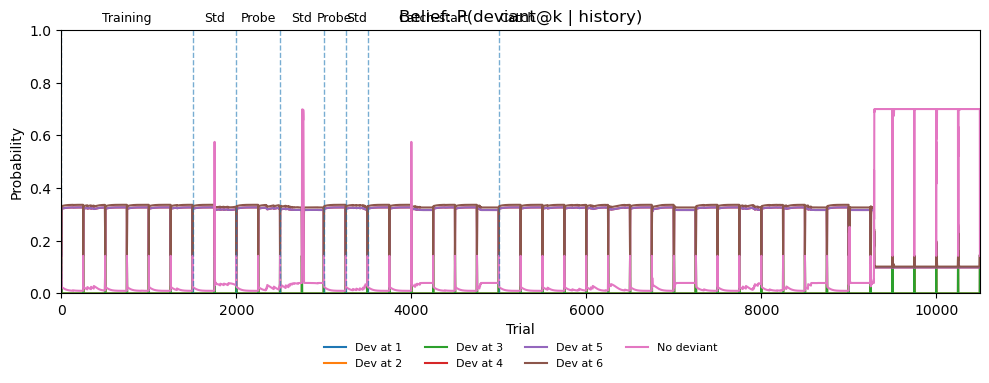

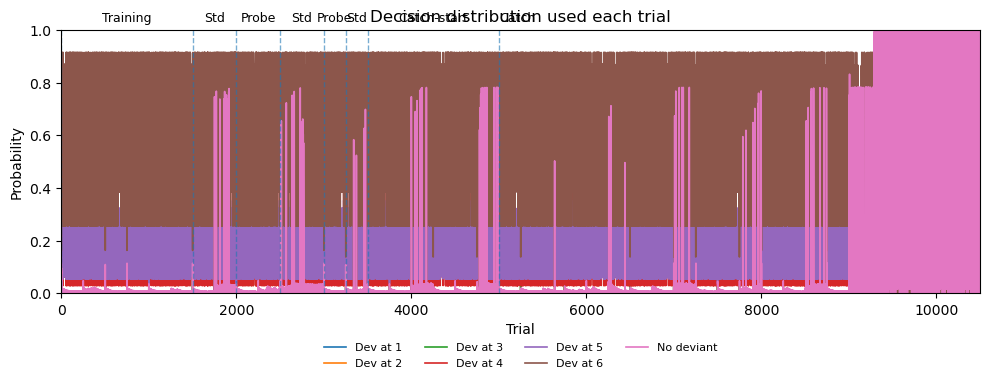

| 13        | -18388.02 | 0.99      | 0.96      | 0.3       | 0.33      | 0.0       | -1.5      | -1.5      | -1.5      | 1.5       | 1.5       | -1.427388 | 1.5       | 0.4770076 | -1.5      | -1.5      | 1.5       |


C:\Users\Fatbu\AppData\Local\Temp\ipykernel_16148\1259146926.py:27: RuntimeWarning: divide by zero encountered in log
  logprior = np.log(prior)


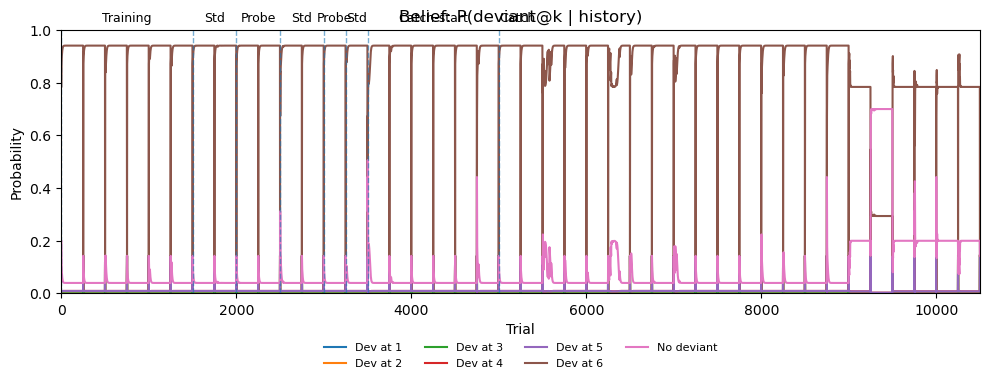

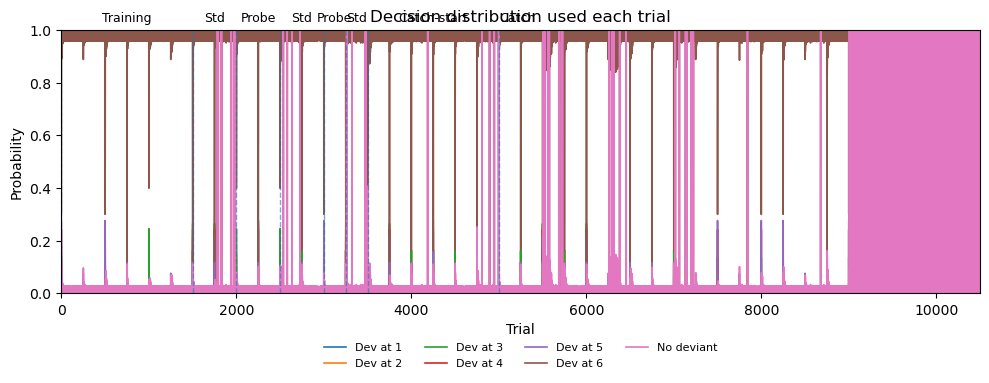

| 14        | -40189.20 | 0.8       | 0.96      | 0.3       | 0.01      | 0.0       | -1.5      | -1.5      | -1.5      | 1.5       | 1.5       | -1.031476 | 1.5       | 0.8053861 | 1.5       | -1.5      | -1.5      |


C:\Users\Fatbu\AppData\Local\Temp\ipykernel_16148\1259146926.py:27: RuntimeWarning: divide by zero encountered in log
  logprior = np.log(prior)


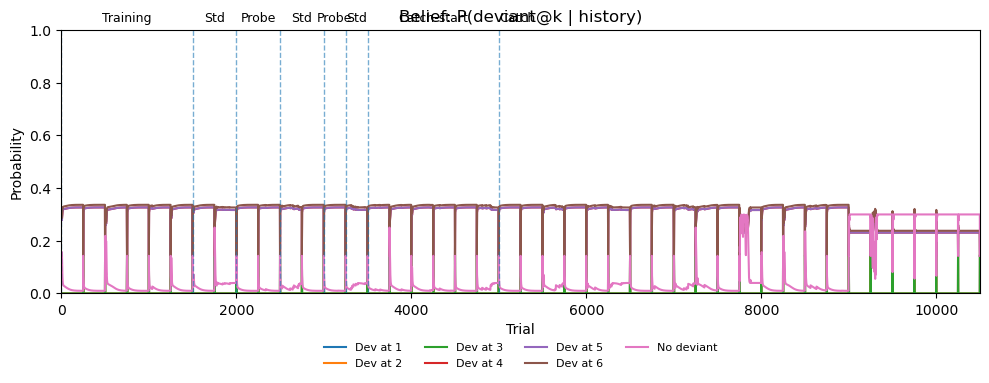

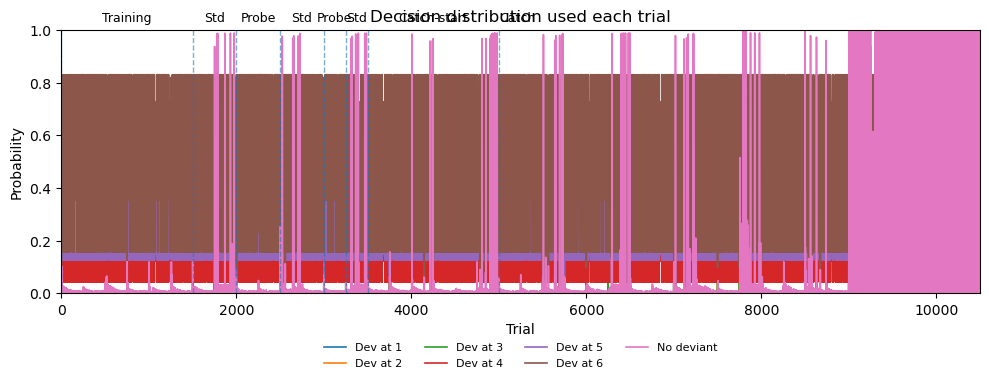

| 15        | -19970.90 | 0.99      | 0.96      | 0.7       | 0.33      | 0.0       | -1.5      | -1.5      | 1.5       | 1.5       | 1.5       | -0.325664 | 1.5       | -0.637376 | -1.5      | -1.5      | 1.5       |


C:\Users\Fatbu\AppData\Local\Temp\ipykernel_16148\1259146926.py:27: RuntimeWarning: divide by zero encountered in log
  logprior = np.log(prior)


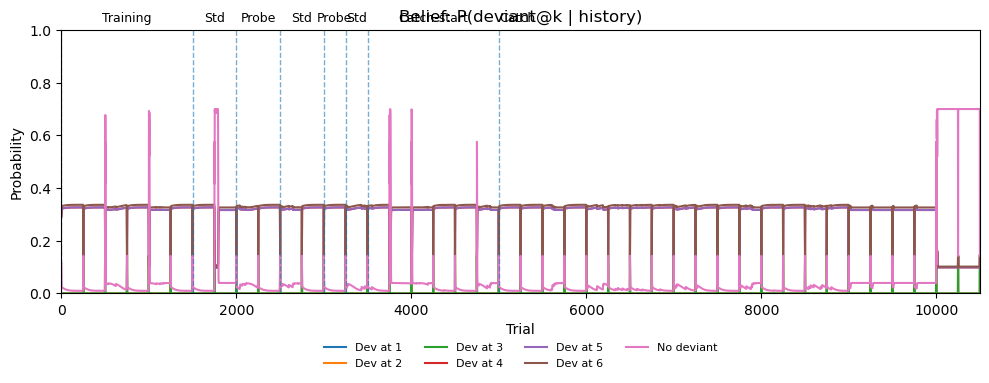

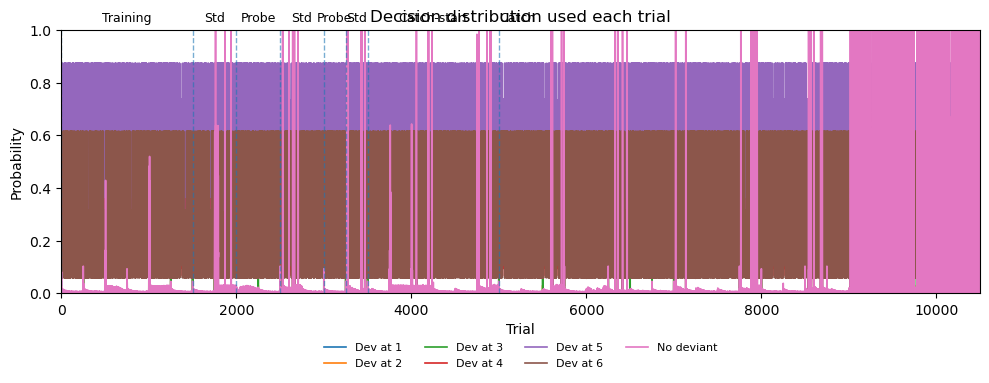

| 16        | -23066.20 | 0.99      | 0.96      | 0.3       | 0.33      | 0.0       | -1.5      | -1.5      | -0.058961 | 1.3229501 | -0.883299 | 1.1121069 | 1.5       | 1.5       | -1.5      | -1.5      | 1.5       |


C:\Users\Fatbu\AppData\Local\Temp\ipykernel_16148\1259146926.py:27: RuntimeWarning: divide by zero encountered in log
  logprior = np.log(prior)


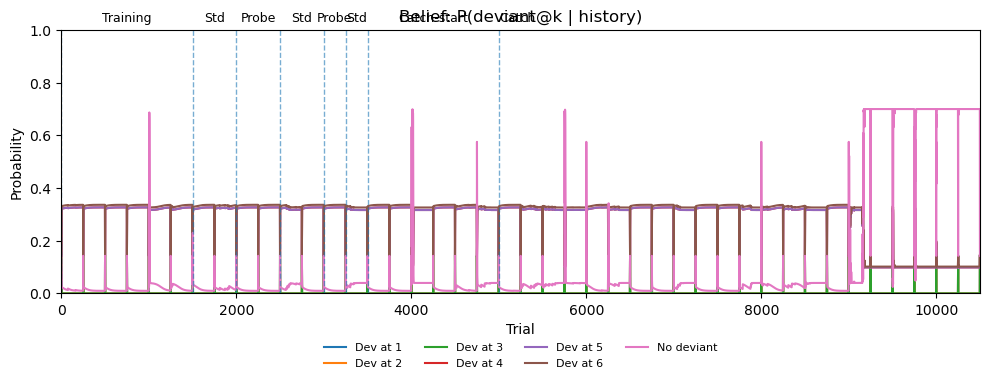

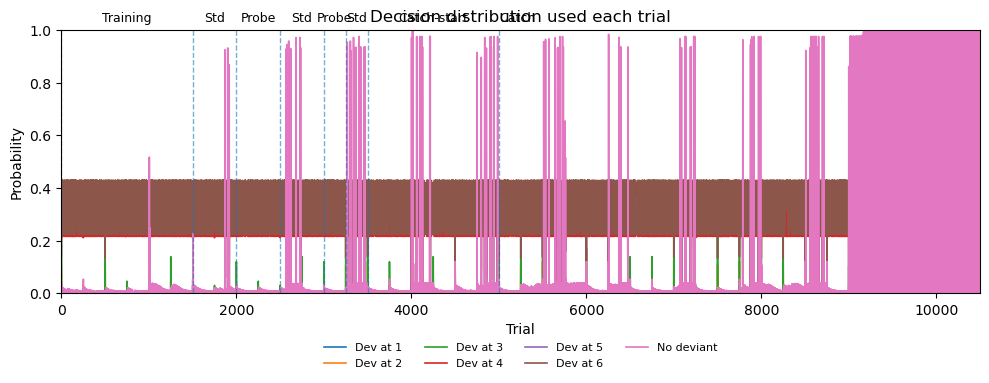

| 17        | -17104.24 | 0.99      | 0.96      | 0.3       | 0.33      | 0.0       | -1.5      | 0.5540952 | -1.449885 | 1.5       | 1.5       | 1.5       | 1.5       | -1.411660 | -1.5      | -1.5      | 1.5       |


C:\Users\Fatbu\AppData\Local\Temp\ipykernel_16148\1259146926.py:27: RuntimeWarning: divide by zero encountered in log
  logprior = np.log(prior)


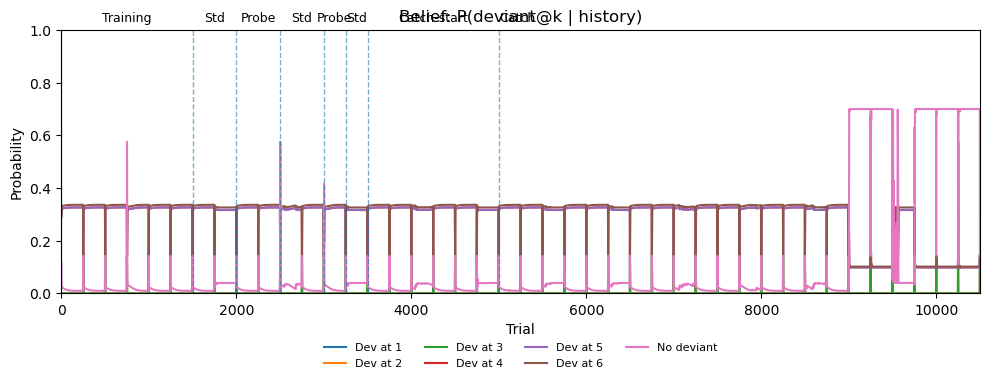

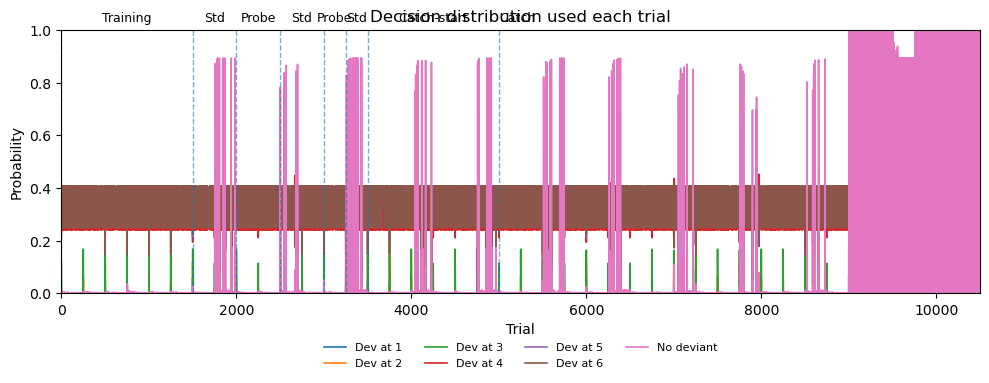

| 18        | -15699.44 | 0.99      | 0.96      | 0.3       | 0.33      | 0.0       | -1.5      | 0.8891865 | 1.5       | 1.5       | 1.5       | 1.5       | 1.5       | -0.861200 | -1.5      | -1.5      | -1.5      |


C:\Users\Fatbu\AppData\Local\Temp\ipykernel_16148\1259146926.py:27: RuntimeWarning: divide by zero encountered in log
  logprior = np.log(prior)


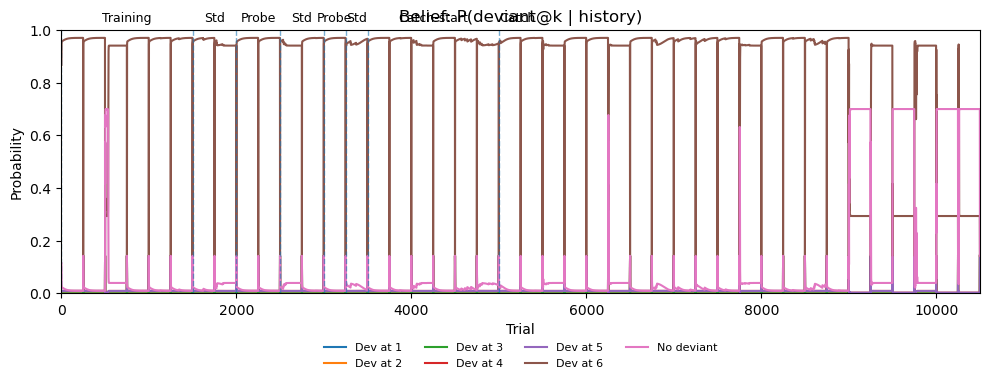

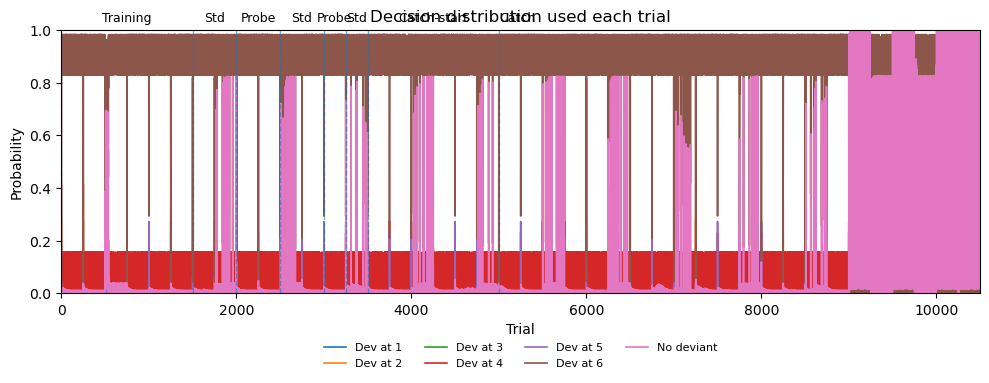

| 19        | -30398.59 | 0.99      | 0.96      | 0.3       | 0.01      | 0.0       | -1.5      | -1.5      | 1.5       | -1.173324 | 1.5       | 1.5       | 1.5       | 1.0232831 | -1.5      | -1.5      | -1.5      |


C:\Users\Fatbu\AppData\Local\Temp\ipykernel_16148\1259146926.py:27: RuntimeWarning: divide by zero encountered in log
  logprior = np.log(prior)


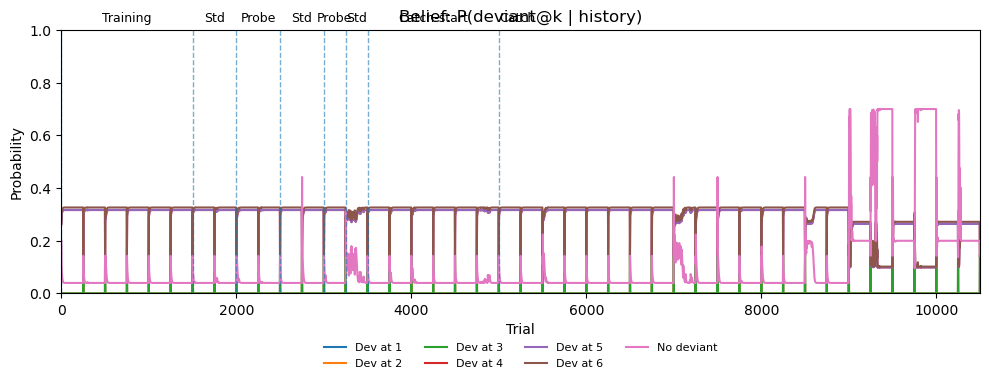

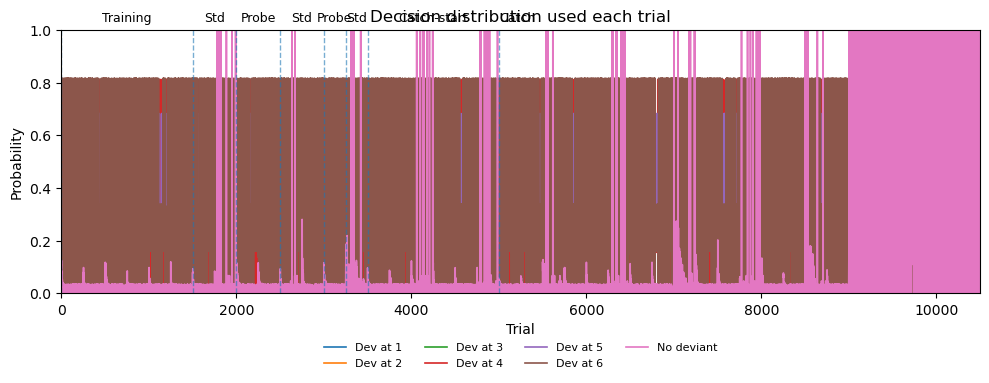

| 20        | -30279.62 | 0.8       | 0.96      | 0.3       | 0.33      | 0.0       | -1.5      | 1.5       | 1.1991069 | 1.5       | 1.5       | 1.5       | 1.5       | 0.9344436 | -1.5      | -1.5      | 1.5       |


C:\Users\Fatbu\AppData\Local\Temp\ipykernel_16148\1259146926.py:27: RuntimeWarning: divide by zero encountered in log
  logprior = np.log(prior)


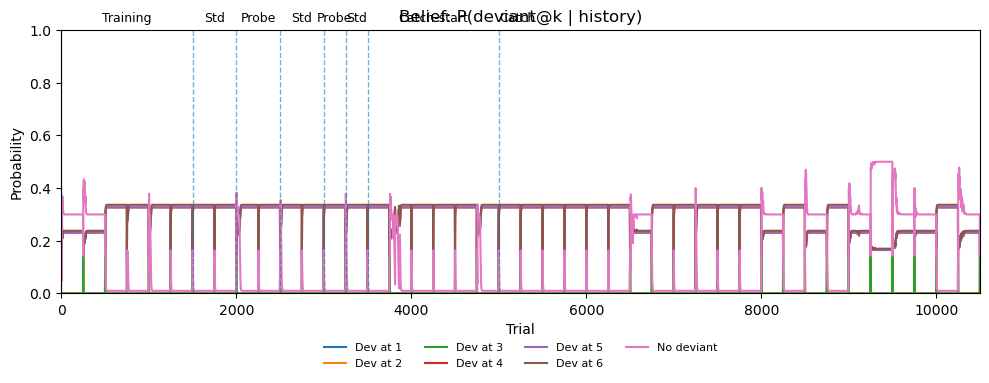

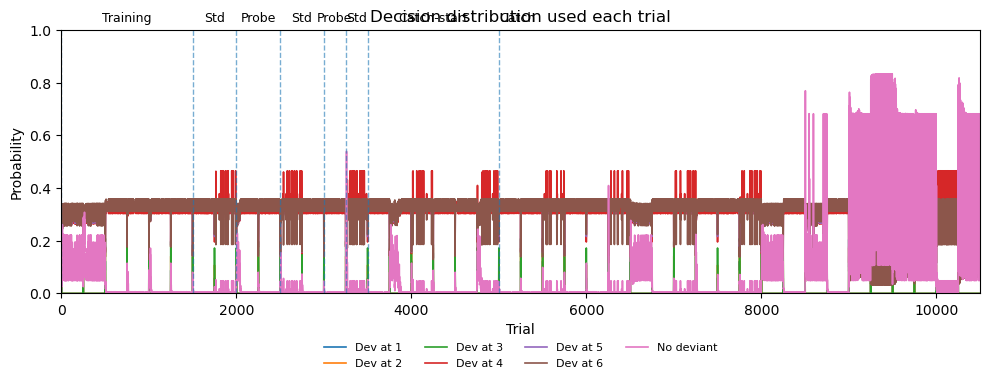

| 21        | -13392.45 | 0.99      | 0.5       | 0.7       | 0.33      | 0.0       | -1.5      | -1.314452 | -0.598073 | 1.5       | 1.5       | 1.5       | 1.5       | -1.5      | -1.5      | -1.5      | -0.980633 |


C:\Users\Fatbu\AppData\Local\Temp\ipykernel_16148\1259146926.py:27: RuntimeWarning: divide by zero encountered in log
  logprior = np.log(prior)


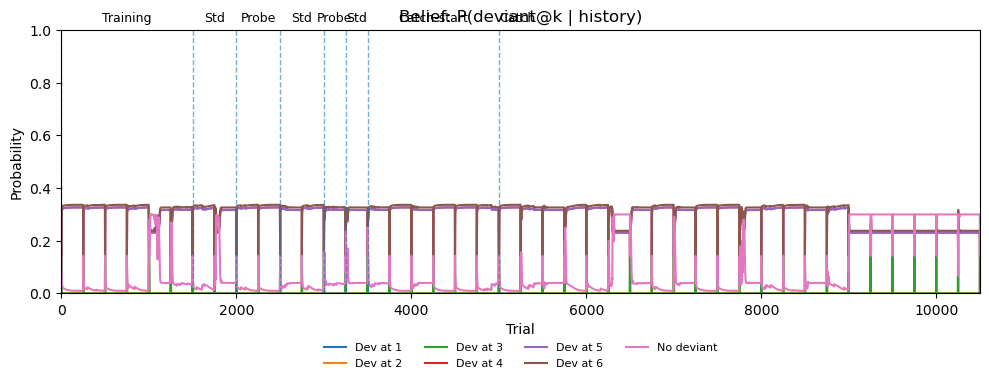

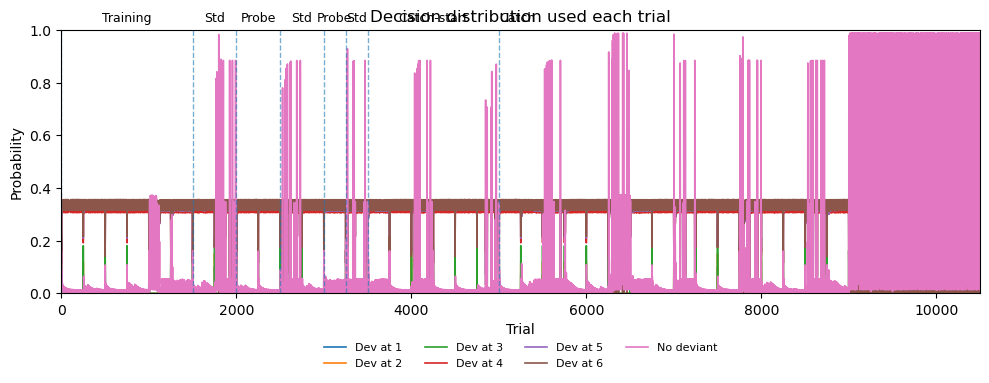

| 22        | -14289.49 | 0.99      | 0.96      | 0.7       | 0.33      | 0.0       | -1.5      | -1.5      | -1.5      | 1.5       | 1.5       | 1.5       | -1.378456 | -1.5      | -1.5      | -1.5      | 0.9860554 |


C:\Users\Fatbu\AppData\Local\Temp\ipykernel_16148\1259146926.py:27: RuntimeWarning: divide by zero encountered in log
  logprior = np.log(prior)


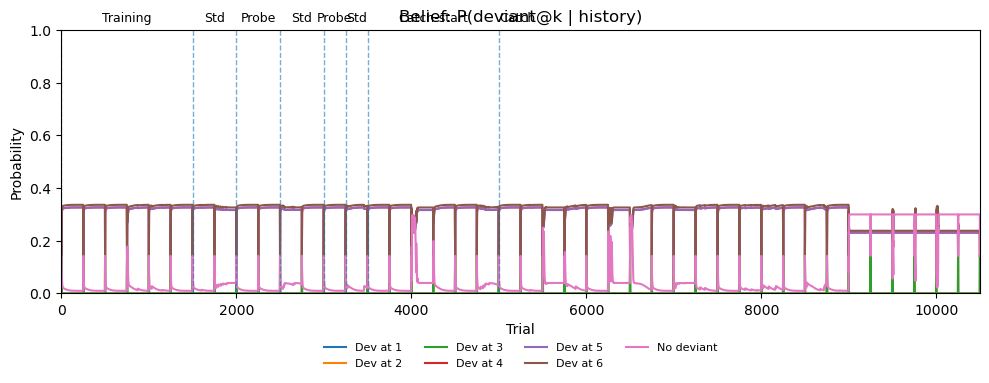

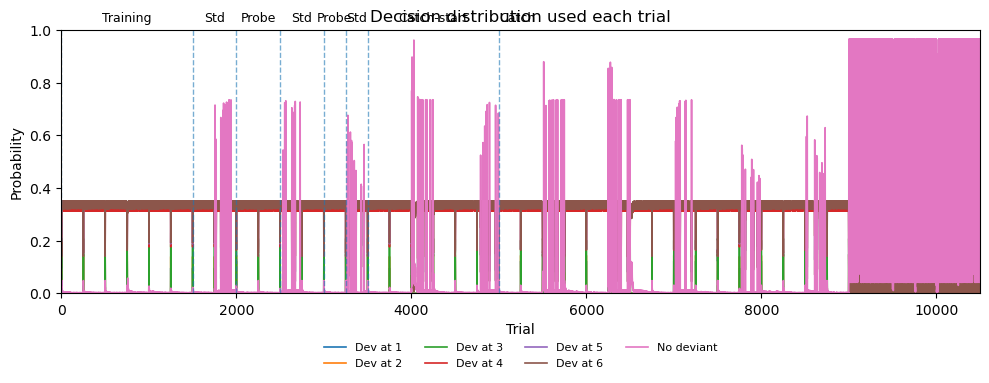

| 23        | -13751.25 | 0.99      | 0.96      | 0.7       | 0.33      | 0.0       | -1.5      | 1.3874705 | -1.5      | 1.5       | 1.5       | 1.5       | -1.092324 | -1.5      | -1.5      | -1.5      | -1.5      |


C:\Users\Fatbu\AppData\Local\Temp\ipykernel_16148\1259146926.py:27: RuntimeWarning: divide by zero encountered in log
  logprior = np.log(prior)


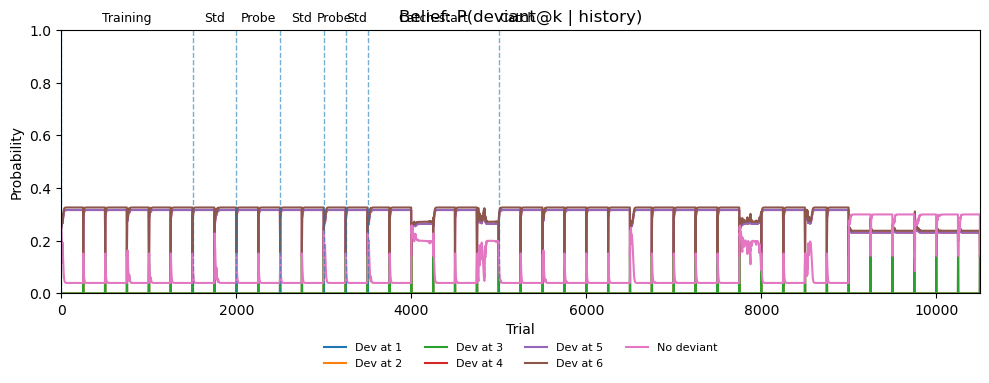

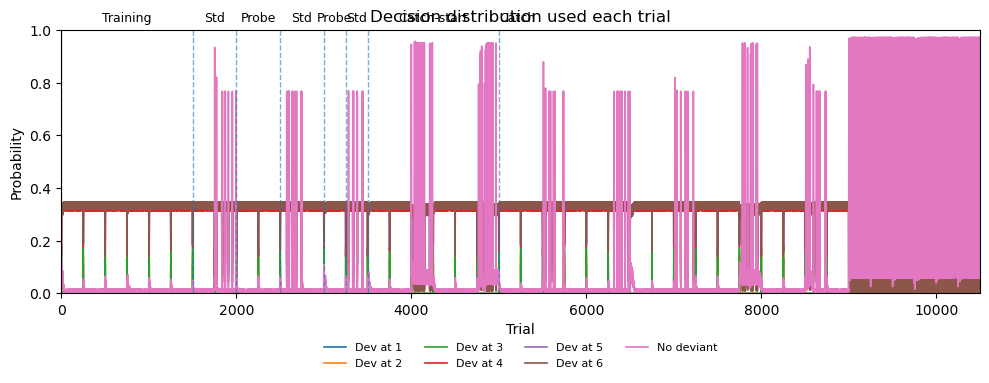

| 24        | -13877.16 | 0.8       | 0.96      | 0.7       | 0.33      | 0.0       | -1.5      | -1.407549 | 1.2197657 | 1.5       | 1.5       | 1.5       | -1.5      | -1.5      | -1.5      | -1.5      | -1.5      |


C:\Users\Fatbu\AppData\Local\Temp\ipykernel_16148\1259146926.py:27: RuntimeWarning: divide by zero encountered in log
  logprior = np.log(prior)


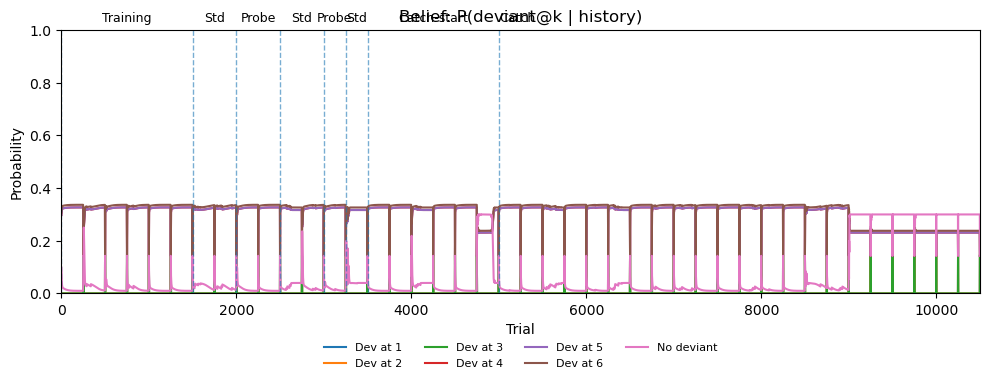

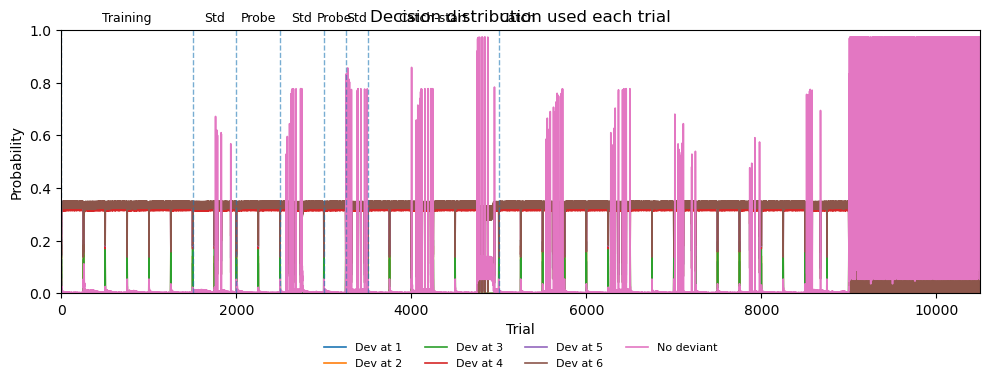

| 25        | -13807.58 | 0.99      | 0.96      | 0.7       | 0.33      | 0.0       | 1.4323691 | -1.5      | -1.5      | 1.5       | 1.5       | 1.5       | -1.5      | -1.5      | -1.5      | -1.5      | -1.5      |


C:\Users\Fatbu\AppData\Local\Temp\ipykernel_16148\1259146926.py:27: RuntimeWarning: divide by zero encountered in log
  logprior = np.log(prior)


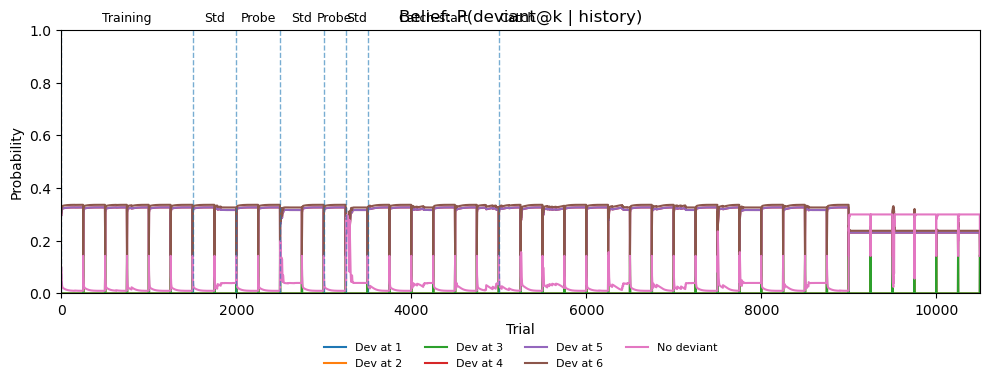

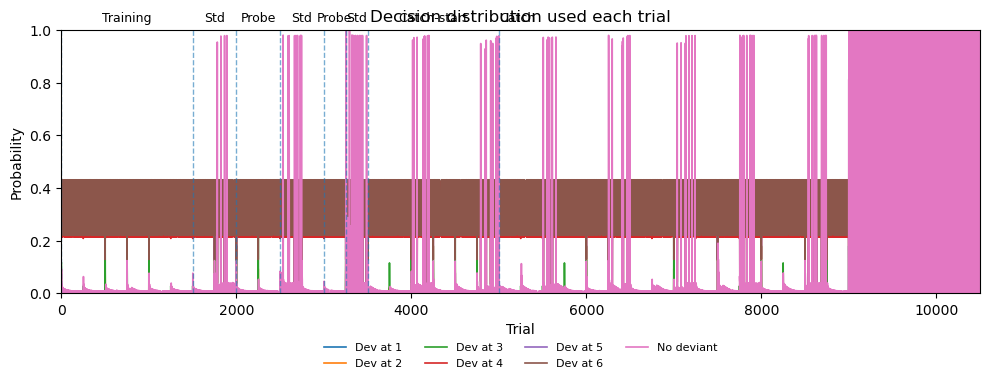

| 26        | -17350.77 | 0.99      | 0.96      | 0.7       | 0.33      | 0.0       | 1.5       | -1.5      | -1.5      | 1.5       | 1.5       | 1.5       | 1.5       | -1.5      | -1.5      | -1.5      | 1.1282014 |


C:\Users\Fatbu\AppData\Local\Temp\ipykernel_16148\1259146926.py:27: RuntimeWarning: divide by zero encountered in log
  logprior = np.log(prior)


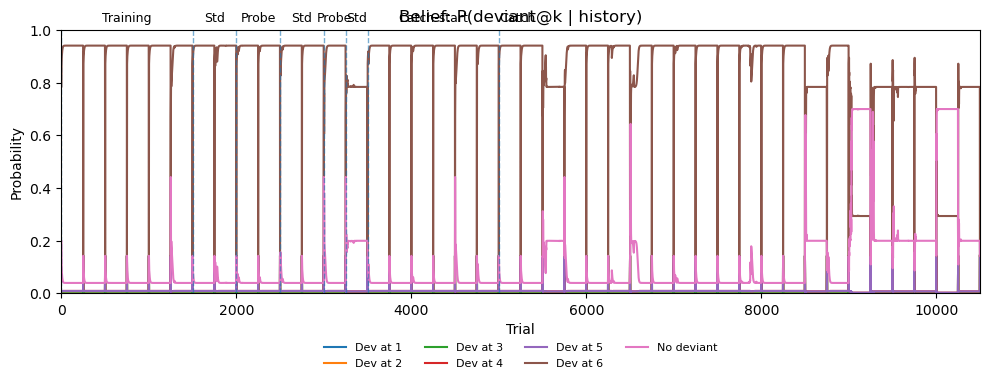

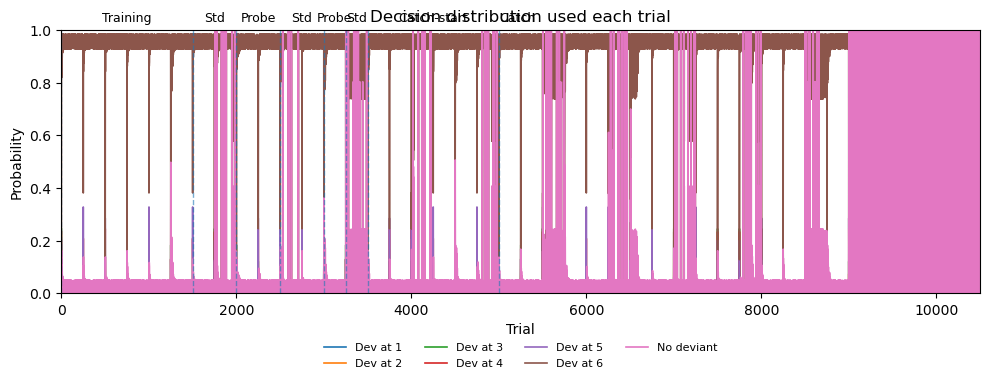

| 27        | -41585.21 | 0.8       | 0.96      | 0.3       | 0.01      | 0.002     | 1.5       | 1.5       | -1.5      | 1.5       | 1.5       | 1.5       | -1.5      | -1.5      | -1.5      | -1.5      | 0.9153812 |


C:\Users\Fatbu\AppData\Local\Temp\ipykernel_16148\1259146926.py:27: RuntimeWarning: divide by zero encountered in log
  logprior = np.log(prior)


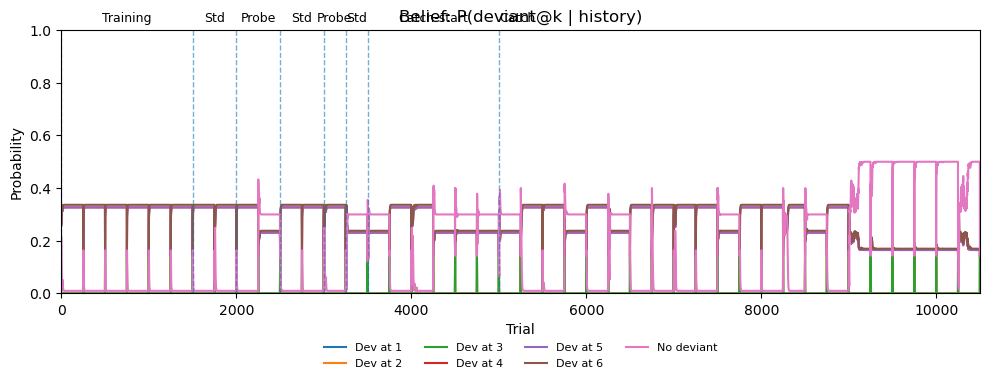

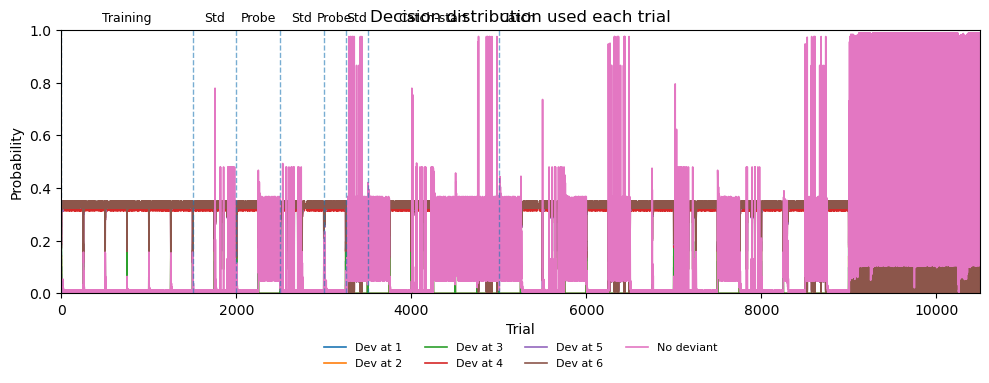

| 28        | -14256.76 | 0.99      | 0.5       | 0.7       | 0.33      | 0.0       | -1.5      | -1.5      | -1.5      | 1.5       | 1.5       | 1.5       | -1.5      | 0.2772446 | -1.5      | -1.5      | -1.5      |


C:\Users\Fatbu\AppData\Local\Temp\ipykernel_16148\1259146926.py:27: RuntimeWarning: divide by zero encountered in log
  logprior = np.log(prior)


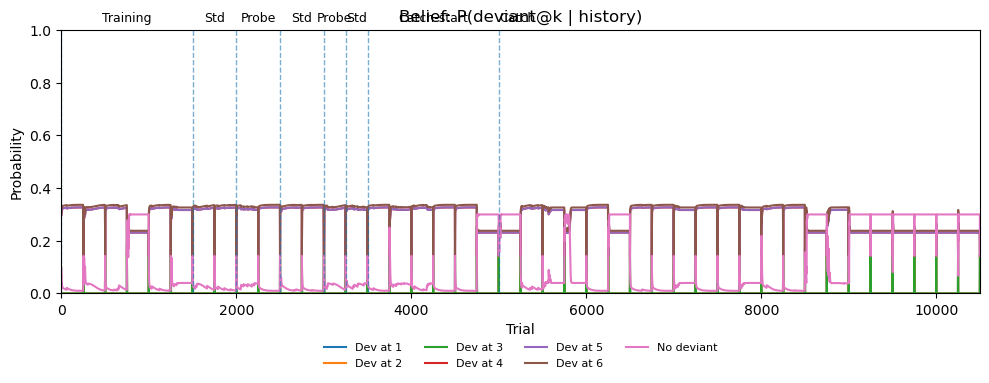

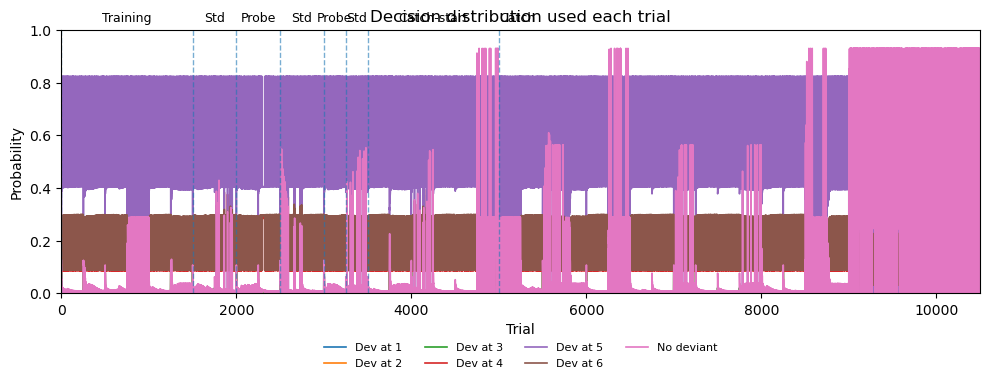

| 29        | -23989.99 | 0.99      | 0.96      | 0.7       | 0.33      | 0.0       | -1.5      | -1.5      | -1.5      | 1.5       | -1.085237 | 1.5       | -1.5      | -1.5      | -1.5      | -1.5      | -1.5      |


C:\Users\Fatbu\AppData\Local\Temp\ipykernel_16148\1259146926.py:27: RuntimeWarning: divide by zero encountered in log
  logprior = np.log(prior)


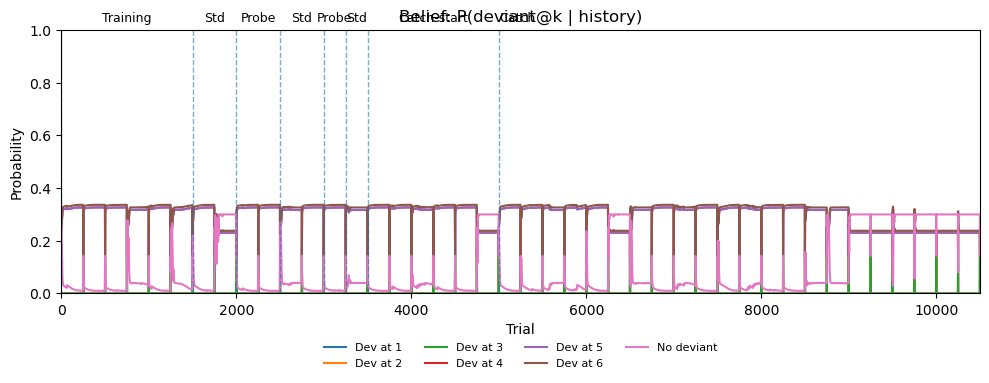

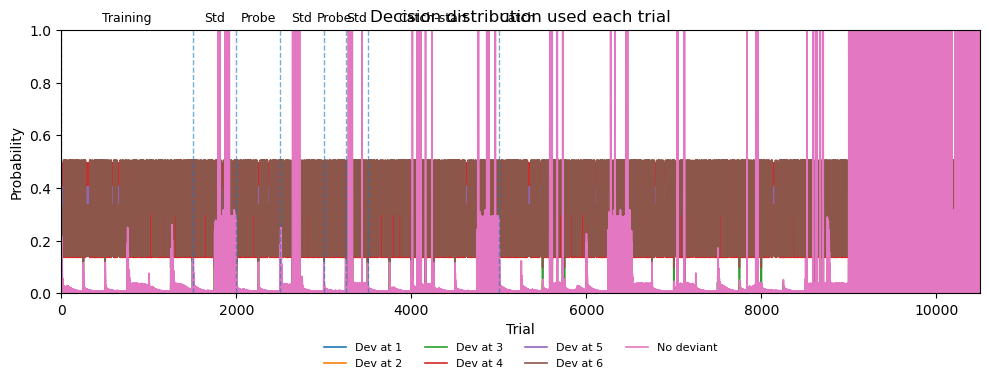

| 30        | -19252.87 | 0.99      | 0.96      | 0.7       | 0.33      | 0.0       | -1.5      | -1.5      | -1.5      | 1.5       | 1.5       | 1.5       | 1.5       | -1.5      | -1.5      | 1.5       | 1.1282993 |


In [5]:
from bayes_opt import BayesianOptimization
import math

def standard_obs(data, trial_count):
    for i in range(trial_count):
        deviant_position = np.random.randint(3, 6)
        data = np.append(data, deviant_position)
    return data

def probe_obs(data, trial_count):
    for i in range(trial_count):
        positions = [3, 4, 5, 6]
        probabilities = [0.95/3, 0.95/3, 0.95/3, 0.05]  
        deviant_position = np.random.choice(positions, size=1, p=probabilities)[0]
        data = np.append(data, deviant_position)
    return data

def catch_obs(data, trial_count):
    for i in range(trial_count):
        positions = [3, 4, 5, 6]
        probabilities = [0.6/3, 0.6/3, 0.6/3, 0.4] 
        deviant_position = np.random.choice(positions, size=1, p=probabilities)[0]
        data = np.append(data, deviant_position)
    return data

data = np.array([])

data = standard_obs(data, 1500)
for i in range(5):
    data = standard_obs(data, 250)
    data = probe_obs(data, 250)
    data = standard_obs(data, 500)
    data = probe_obs(data, 250)
    data = standard_obs(data, 250)
data = catch_obs(data, 1500)

print(data)


#f1 set to zero as reference variance
def neg_log_likelihood(hm_standard, hm_probe, hm_catch, dev4, lamdha_, a1, a2, a3, a4, a5, a6, a7, f1, f2, f3, f4):
    trial_by_global = np.array([
        [hm_standard, 1 - hm_standard],
        [hm_probe, 1 - hm_probe],
        [hm_catch, 1 - hm_catch]
    ]).T
    trial_by_logic = np.array([
        [0, 0,0, dev4, dev4, 1 - (2 * dev4), 0],
        [0, 0, 0, 0, 0, 0, 1]
    ]).T

    pos_sigma_ = np.asarray([a1, a2, a3, a4, a5, a6, a7])
    pos_sigma_ -= pos_sigma_.mean()

    freq_sigma_ = np.asarray([f1, f2, f3, f4])
    freq_sigma_ -= freq_sigma_.mean()

    priors = change_point_model(trial_by_global, trial_by_logic, lamdha_, pos_sigma_, freq_sigma_)
    priors = np.asarray(priors, dtype=float)

    if len(priors) != len(data):
        raise ValueError(f"Length mismatch: priors={len(priors)} vs data={len(data)}")

    # floor + nan guard
    eps = 1e-12
    priors = np.where(np.isfinite(priors), priors, 0.0)
    priors = np.maximum(priors, eps)

    nll = 0.0
    for i in range(len(priors)):
        k = int(data[i])                  # 3..6 by your generators
        p = priors[i, k]                  # belief mass at that class
        nll -= math.log(p)                # accumulate negative log-likelihood
    return -nll  #have to negate since bayesian optimizer is a maximizer not a minimizer

# Define bounds for each parameter (between 0.01 and 0.99 to avoid degenerate values)
pbounds = {
    'hm_standard': (0.8, 0.99),
    'hm_probe': (0.5, 0.96),
    'hm_catch': (0.3, 0.7),
    'dev4': (0.01, 0.33),
    'lamdha_': (0, 0.002),
    'a1': (-1.5, 1.5),
    'a2': (-1.5, 1.5),
    'a3': (-1.5, 1.5),
    'a4': (-1.5, 1.5),
    'a5': (-1.5, 1.5),
    'a6': (-1.5, 1.5),
    'a7': (-1.5, 1.5),
    'f1': (-1.5, 1.5),
    'f2': (-1.5, 1.5),
    'f3': (-1.5, 1.5),
    'f4': (-1.5, 1.5),
}

# Initialize the optimizer
optimizer = BayesianOptimization(
    f=neg_log_likelihood,
    pbounds=pbounds,
    random_state=42,
    verbose=2
)

# Run optimization
optimizer.maximize(
    init_points=10,  # random samples before GP fitting
    n_iter=20        # number of iterations of Bayesian optimization
)    